In [1]:
#✅ Part 1: Load & Preprocess Dataset

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("KaggleV2-May-2016.csv")

# Basic cleaning
df.rename(columns=lambda x: x.strip().replace("-", "_"), inplace=True)
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])
df['WaitingDays'] = (df['AppointmentDay'] - df['ScheduledDay']).dt.days
df = df[df['Age'] >= 0]  # Remove invalid age

# Convert target
df['No_show'] = df['No_show'].map({'No': 0, 'Yes': 1})

# Sort by patient and appointment date
df = df.sort_values(by=['PatientId', 'ScheduledDay'])

# Create new features
df['Total_Prior_Appointments'] = df.groupby('PatientId').cumcount()
df['Total_Missed_Appointments'] = df.groupby('PatientId')['No_show'].cumsum().shift(fill_value=0)

# Encode categorical
df['Gender'] = LabelEncoder().fit_transform(df['Gender'])
df['DayOfWeek'] = df['AppointmentDay'].dt.dayofweek

# Features for model
features = ['Age', 'Gender', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism',
            'Handcap', 'SMS_received', 'WaitingDays', 'DayOfWeek',
            'Total_Prior_Appointments', 'Total_Missed_Appointments']

X = df[features]
y = df['No_show']

In [7]:
#✅ Part 2: Handle Class Imbalance with SMOTE

# SMOTE for imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [8]:
#✅ Part 3: Train Model (Random Forest)

model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.75      0.78     17594
           1       0.77      0.82      0.79     17689

    accuracy                           0.78     35283
   macro avg       0.79      0.78      0.78     35283
weighted avg       0.79      0.78      0.78     35283

Accuracy: 78.50%
ROC AUC Score: 0.8637449191692421


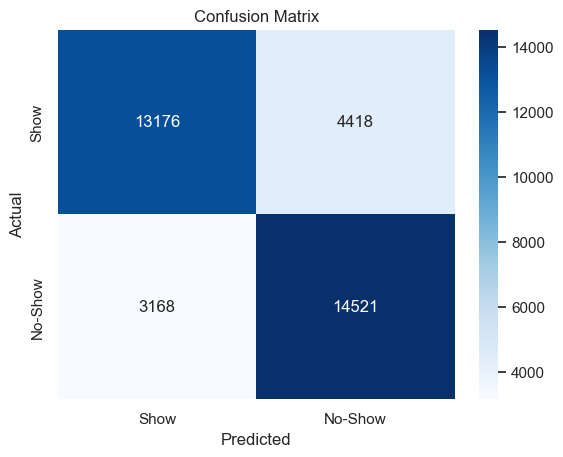

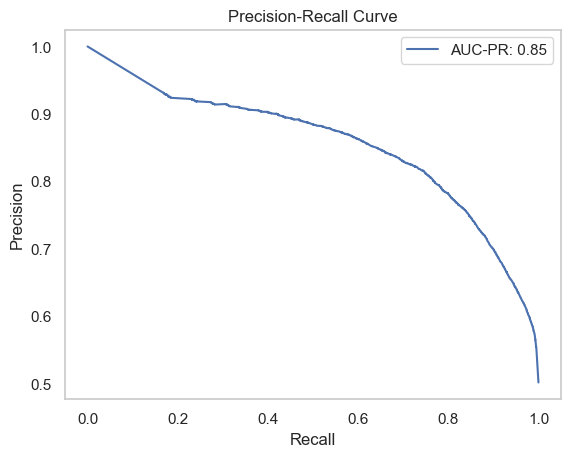

In [9]:
#✅ Part 4: Evaluation & Metrics

from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, precision_recall_curve,
    auc, accuracy_score
)

# ✅ Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# ✅ Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2%}")  # As percentage

# ✅ ROC AUC Score
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

# ✅ Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Show', 'No-Show'], yticklabels=['Show', 'No-Show'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ✅ Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
auc_pr = auc(recall, precision)
plt.plot(recall, precision, label=f'AUC-PR: {auc_pr:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()


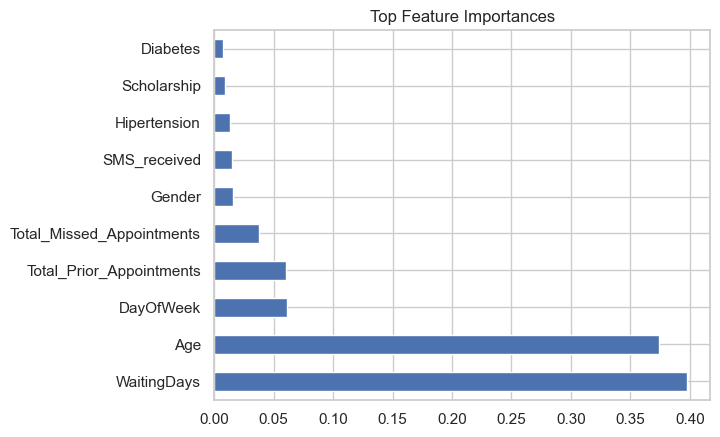

In [10]:
#✅ Optional: Feature Importance

# Feature importance
importances = pd.Series(model.feature_importances_, index=features)
importances.nlargest(10).plot(kind='barh')
plt.title("Top Feature Importances")
plt.show()